In [11]:
# 필요한 모듈 불러오기 및 시드 고정
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, ConvLSTM2D, Conv3D, BatchNormalization, Lambda, Reshape
from tensorflow.keras.optimizers import Adadelta
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
# import data_preprocessing_codes.data_preprocessing as dpp
from keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
tf.random.set_seed(1)
np.random.seed(1)

In [2]:
import requests

# 파일 URL
file_url = "https://drive.usercontent.google.com/download?id=13OWZ6a-tgj09MAExmL7tQo-M4KQ8mNiz&export=download&authuser=0&confirm=t&uuid=924d1eb4-74f8-4b8e-89e6-118340faef32&at=APvzH3q5QeTI6otMfailzVkPBv6B%3A1734636050976"

# 요청하여 파일 다운로드
response = requests.get(file_url, stream=True)

# 파일이 성공적으로 다운로드되었는지 확인
if response.status_code == 200:
    # 파일 저장 경로
    save_path = "testData_1116~1121_input_1h.npy"
    with open(save_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):  # 청크 단위로 파일을 다운로드하여 메모리 절약
            file.write(chunk)
    print(f"파일이 성공적으로 다운로드되었습니다: {save_path}")
else:
    print(f"파일 다운로드 실패: {response.status_code}")

파일이 성공적으로 다운로드되었습니다: testData_1116~1121_input_1h.npy


In [12]:
inputs = np.load("trainData_1122~1215_input_1h.npy")
outputs = np.load("trainData_1122~1215_output_1h.npy")

In [13]:
inputs.shape, outputs.shape

((1410, 11, 40, 40, 4), (1410, 1, 40, 40, 4))

In [14]:
# 자 모델 구축 들갑니다~
model = Sequential()
model.add(ConvLSTM2D(filters=40, 
                     kernel_size=(3,3), 
                     input_shape=(None,40,40,4), 
                     padding="same", 
                     return_sequences=True))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=40, 
                     kernel_size=(3,3), 
                     padding="same", 
                     return_sequences=True))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=40, 
                     kernel_size=(3,3), 
                     padding="same", 
                     return_sequences=True))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=40, 
                     kernel_size=(3,3), 
                     padding="same", 
                     return_sequences=False))
model.add(Reshape((1, 40, 40, 40)))
model.add(BatchNormalization())
model.add(Conv3D(filters=4, 
                 kernel_size=(3,3,3), 
                 activation="sigmoid",
                 padding="same"))
optimizer = Adadelta(learning_rate=2.0)
model.compile(loss='binary_crossentropy',optimizer="adam", metrics = ['accuracy'])
callbacks_val_acc = [EarlyStopping(monitor='val_accuracy', patience=7, mode='max', restore_best_weights=True),
                     ModelCheckpoint("ClimateAI.keras", monitor='val_accuracy', save_best_only=True)]
callbacks_val_loss = [EarlyStopping(monitor='val_loss', patience=7, mode='min', restore_best_weights=True),
                      ModelCheckpoint("ClimateAI.keras", monitor='val_loss', save_best_only=True)]
callbacks = [callbacks_val_acc, callbacks_val_loss]

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_4 (ConvLSTM2D)  (None, None, 40, 40, 40   63520     
                             )                                   
                                                                 
 batch_normalization_4 (Bat  (None, None, 40, 40, 40   160       
 chNormalization)            )                                   
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, None, 40, 40, 40   115360    
                             )                                   
                                                                 
 batch_normalization_5 (Bat  (None, None, 40, 40, 40   160       
 chNormalization)            )                                   
                                                                 
 conv_lstm2d_6 (ConvLSTM2D)  (None, None, 40, 40, 40  

In [15]:
model.fit(inputs, outputs, epochs=15, batch_size=2, validation_split=0.1)

Epoch 1/15
635/635 [==============================] - 187s 275ms/step - loss: 0.4332 - accuracy: 0.9764 - val_loss: 0.4312 - val_accuracy: 0.9978
Epoch 2/15
635/635 [==============================] - 173s 272ms/step - loss: 0.4023 - accuracy: 0.9968 - val_loss: 0.4104 - val_accuracy: 0.9978
Epoch 3/15
635/635 [==============================] - 172s 271ms/step - loss: 0.3839 - accuracy: 0.9968 - val_loss: 0.4102 - val_accuracy: 0.9978
Epoch 4/15
635/635 [==============================] - 176s 277ms/step - loss: 0.3789 - accuracy: 0.9968 - val_loss: 0.4067 - val_accuracy: 0.9978
Epoch 5/15
635/635 [==============================] - 171s 269ms/step - loss: 0.3775 - accuracy: 0.9968 - val_loss: 0.4055 - val_accuracy: 0.9978
Epoch 6/15
635/635 [==============================] - 172s 270ms/step - loss: 0.3771 - accuracy: 0.9968 - val_loss: 0.4041 - val_accuracy: 0.9978
Epoch 7/15
635/635 [==============================] - 174s 273ms/step - loss: 0.3767 - accuracy: 0.9968 - val_loss: 0.4046 -

In [16]:
model.save("lgs-PB(16).keras")

In [19]:
loded_model = tf.keras.models.load_model("lgs-PB(16).keras")

In [20]:
test_data = inputs[:]
predict = loded_model.predict(test_data)
predict = predict.astype("float32")

45/45 [==============================] - 3s 37ms/step


In [21]:
predict.shape, test_data.shape

((1410, 1, 40, 40, 4), (1410, 11, 40, 40, 4))

In [23]:
def show_result(select_time):
    plt.figure(figsize=(30, 15))

    for i in range(11):
        plt.subplot(3, 6, i+1)
        plt.imshow(test_data[select_time, i, :, :, :])
        plt.xlabel(f"frame_{i+1}")

    plt.subplot(3, 6, 13)
    plt.imshow(predict[select_time, 0, :, :, :])
    plt.xlabel("prediction (frame_12)")
    plt.subplot(3, 6, 14)
    plt.imshow(outputs[select_time,0,:,:,:])
    plt.xlabel("Real data (frame_12)")
    plt.show()

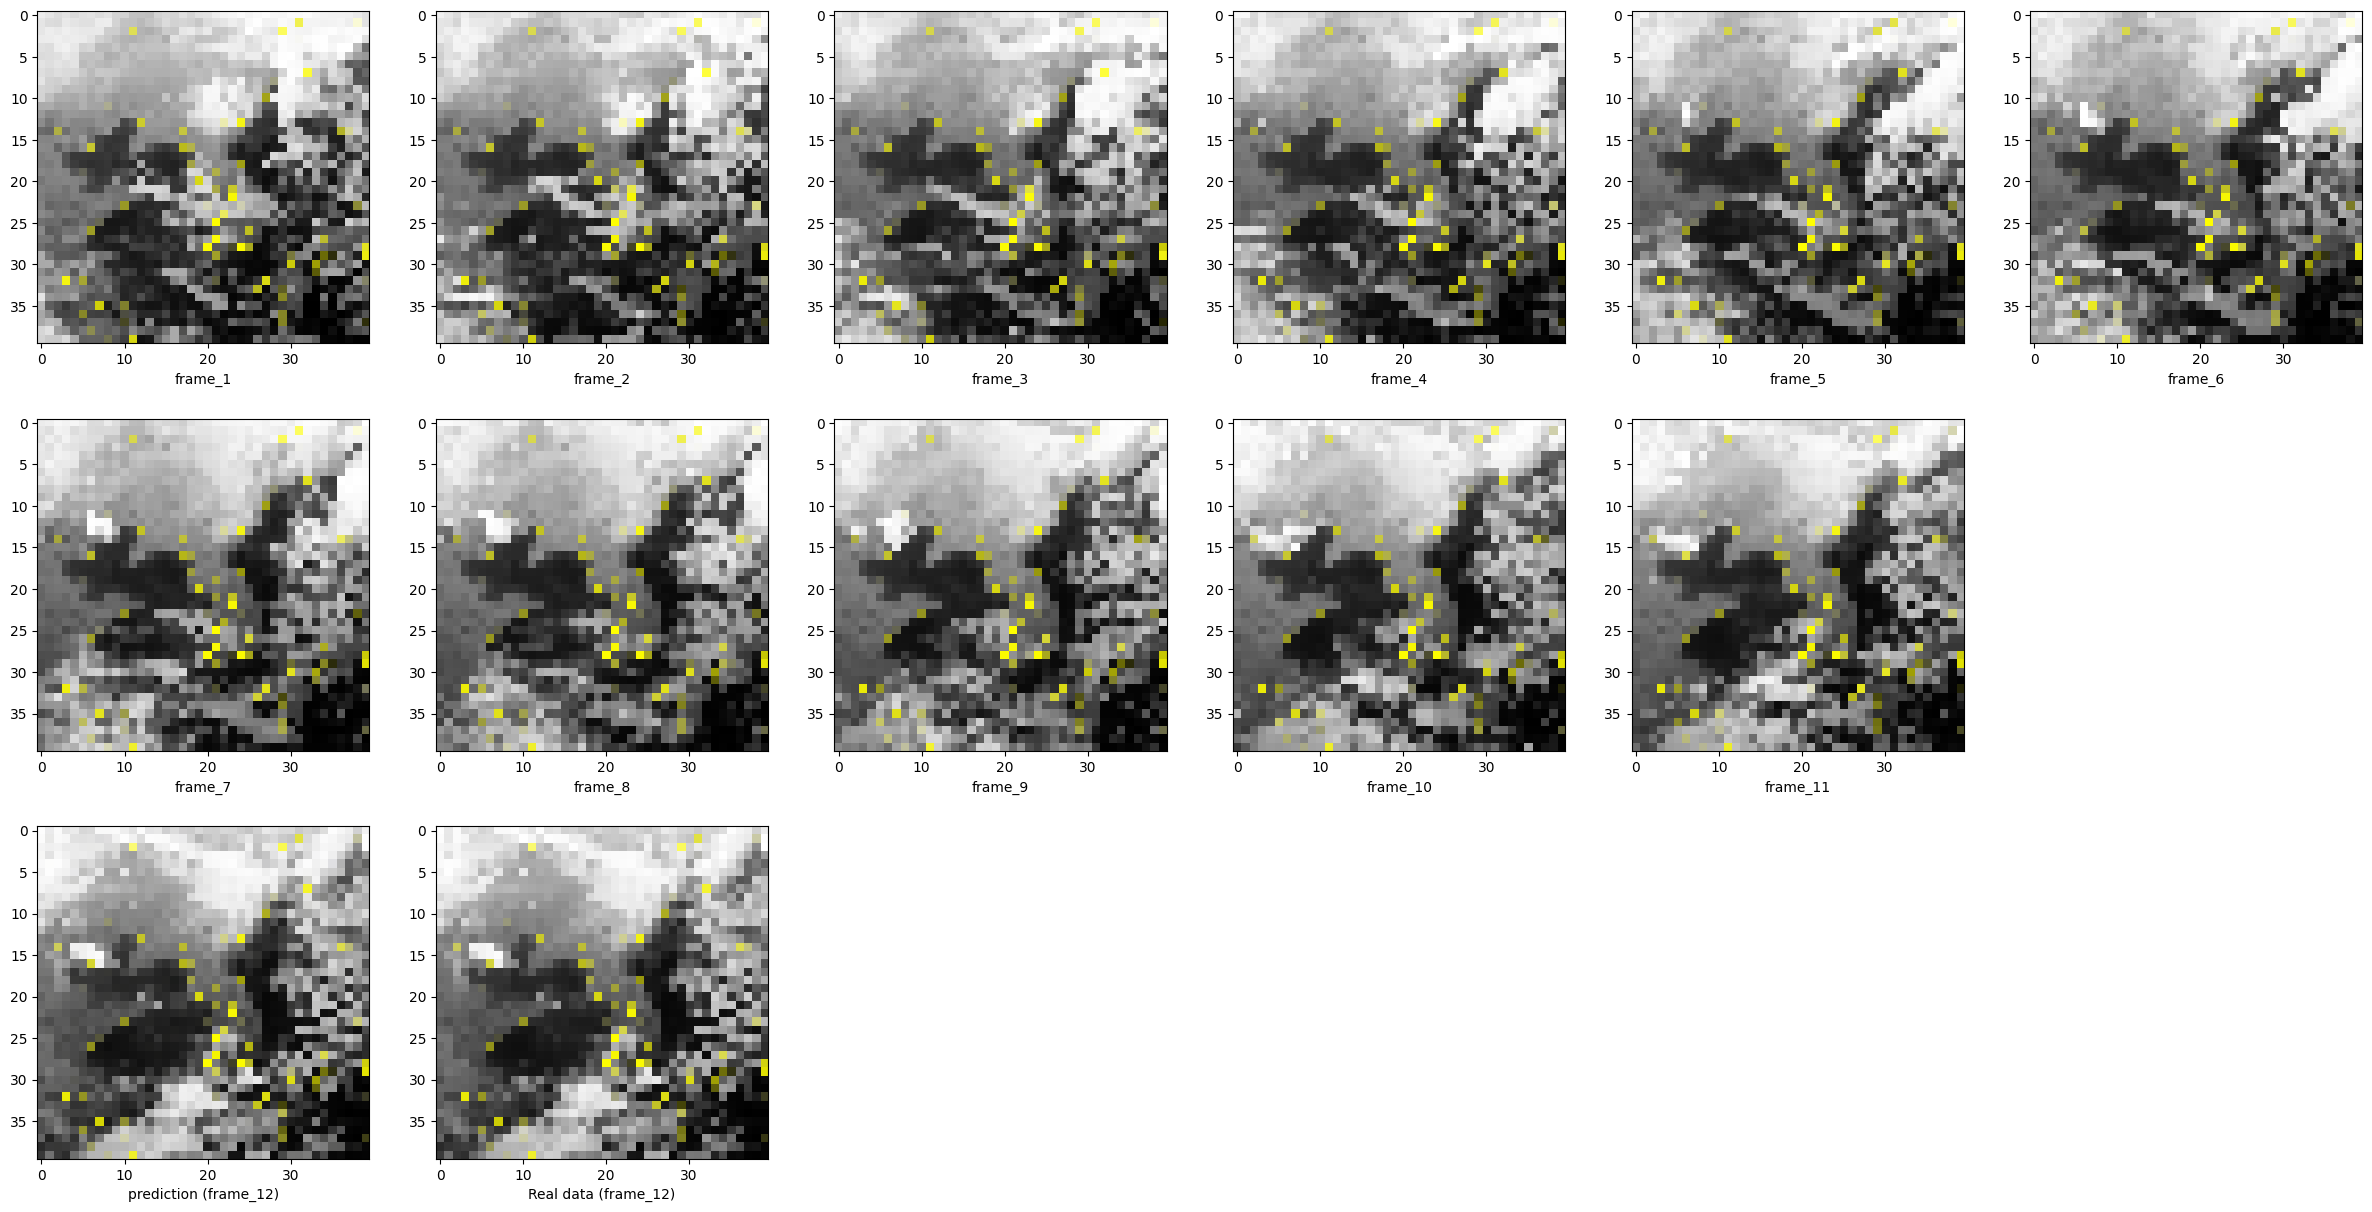

In [24]:
show_result(100)

In [ ]:
# 테스트 데이터로 검증 드가자

In [18]:
loded_model = tf.keras.models.load_model("lgs-PB(16).keras")

In [25]:
test_input = np.load("testData_1116~1121_input_1h.npy")
test_output = np.load("testData_1116~1121_output_1h.npy")

In [26]:
test_data = test_input
predict = loded_model.predict(test_data)
predict = predict.astype("float32")

11/11 [==============================] - 1s 46ms/step


In [27]:
def show_result_by_test_data(select_time, save_path=None):
    """
    Test data visualization function with optional saving.

    Parameters:
    - select_time (int): Index of the test data time step to visualize.
    - save_path (str, optional): Path to save the generated figure. If None, it won't save.
    """
    plt.figure(figsize=(30, 15))

    for i in range(11):
        plt.subplot(3, 6, i + 1)
        plt.imshow(test_data[select_time, i, :, :, :])
        plt.xlabel(f"frame_{i+1}")

    plt.subplot(3, 6, 13)
    plt.imshow(predict[select_time, 0, :, :, :])
    plt.xlabel("prediction (frame_12)")

    plt.subplot(3, 6, 14)
    plt.imshow(test_output[select_time, 0, :, :, :])
    plt.xlabel("Real data (frame_12)")

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Image saved to {save_path}")
    else:
        plt.show()

In [28]:
test_data.shape

(330, 11, 40, 40, 4)

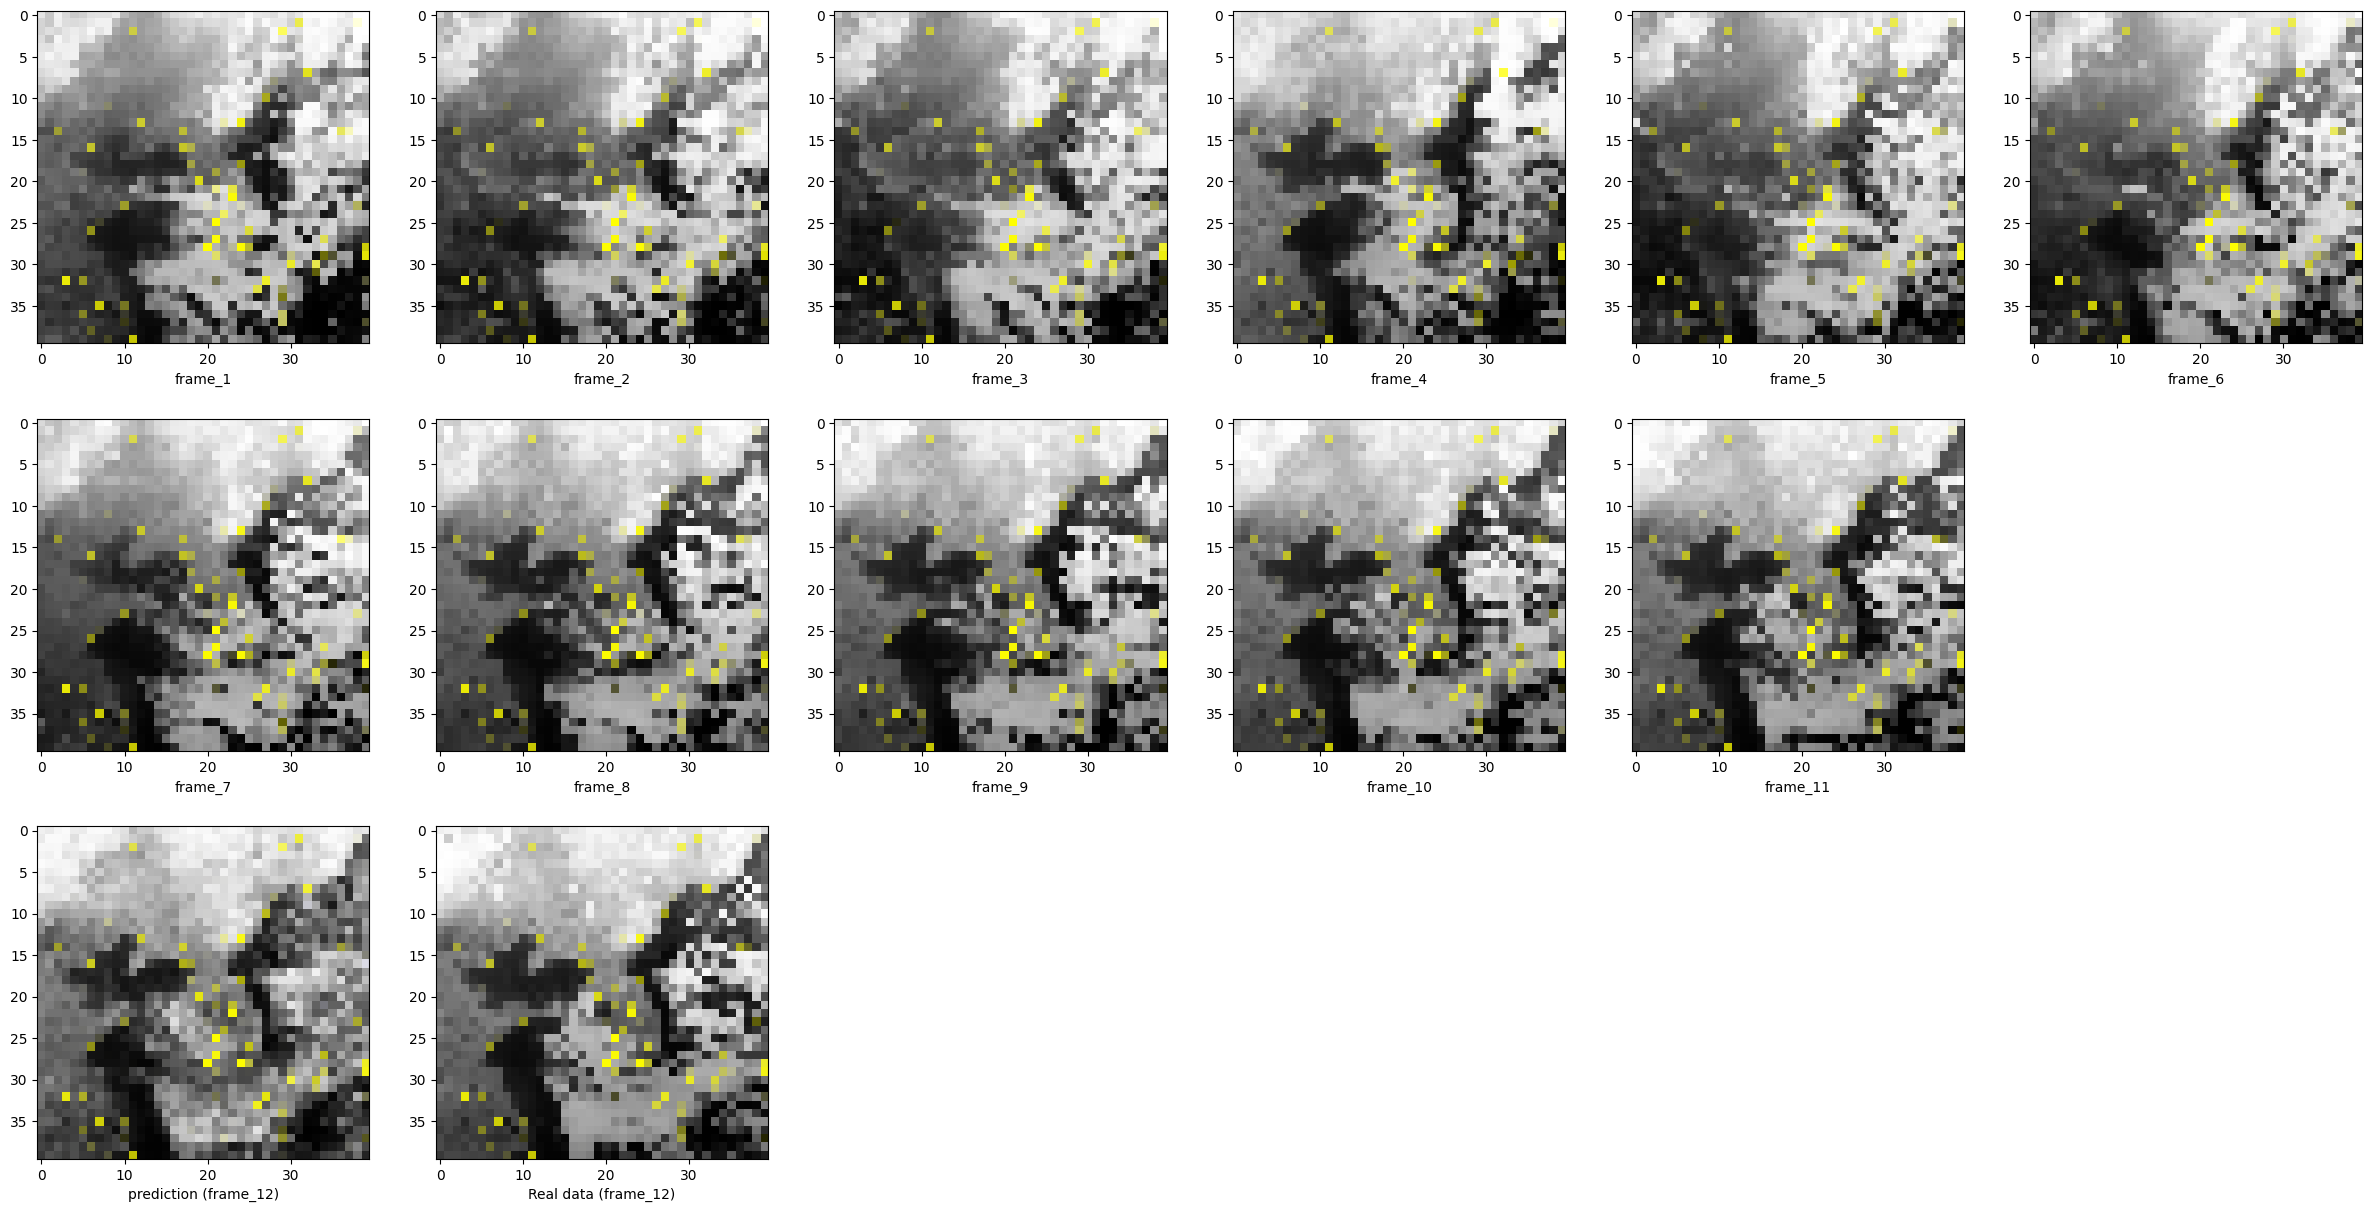

In [40]:
show_result_by_test_data(300)